# Bigmart Sales Data Set:Predict the sales of a store

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities.Retail is another industry which extensively uses analytics to optimize business processes. Tasks like product placement, inventory management, customized offers, product bundling, etc. are being smartly handled using data science techniques. As the name suggests, this data comprises of transaction records of a sales store. This is a regression problem. The data has 8523 rows of 12 variables.

In [358]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns

from random import random
from scipy.stats import mode
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,median_absolute_error,mean_squared_log_error

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Data Exploration

In [250]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [251]:
#adding source column to both train and test data sets for intial data exploration 
train['source']='train'
test['source']='test'
data=pd.concat([train,test],ignore_index=True)
train.shape,test.shape,data.shape

((8523, 13), (5681, 12), (14204, 13))

In [252]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [254]:
#Check missing values
data.apply(lambda x:sum(x.isnull())) #or data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

 Item_Outlet_Sales is the target variable and missing values are ones in the test set. So we need not worry about it. But we’ll impute the missing values in Item_Weight and Outlet_Size in the data cleaning section.

Some basic statistics for numeric variables

In [255]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


observations: 
1. Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0
2. Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
3. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.

Now let us look categorical variables. Let us look at the number of unique values in each of them.

In [256]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

This tells us that there are 1559 products and 10 outlets/stores. Another thing that should catch attention is that Item_Type has 16 unique values. Let’s explore further using the frequency of different categories in each nominal variable. I’ll exclude the ID and source variables for obvious reasons.

In [257]:
#Filter categorical variables
categorical_columns=[x for x in data.dtypes.index if data.dtypes[x]=='object']
categorical_columns

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'source']

In [258]:
#Exclude Item Identifier, Outlet Identifier and Source columns
categorical_columns= [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]

#print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

The output gives us following observations:

Item_Fat_Content: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘reg’.

Item_Type: Not all categories have substantial numbers. It looks like combining them can give better results.

Outlet_Type: Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

# Data Cleaning

This step typically involves imputing missing values and treating outliers. Though outlier removal is very important in regression techniques, advanced tree based algorithms are impervious to outliers. So I’ll leave it to you to try it out. We’ll focus on the imputation step here, which is a very important step.

### Imputing Missing Values

We found two variables with missing values – Item_Weight and Outlet_Size. Lets impute the former by the average weight of the particular item.

In [259]:
#Determine the average weight per item:
item_avg_weight=data.pivot_table(values='Item_Weight',index='Item_Identifier')

In [260]:
item_avg_weight.loc['DRA12']

Item_Weight    11.6
Name: DRA12, dtype: float64

In [261]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d' %sum(miss_bool))


Orignal #missing: 2439


In [262]:
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Final #missing: 0


In [263]:
#Imputing Outlet Size
#from scipy.stats import mode

# defining mode for each outlet type
outlet_size_mode=data.pivot_table(values='Outlet_Size',index='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]))

In [264]:
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

Mode for each Outlet_Type:
                  Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium


In [265]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

##Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d' %sum(miss_bool))
data.loc[miss_bool,'Outlet_Size']=data.loc[miss_bool,'Outlet_Type'].apply(lambda x:outlet_size_mode.loc[x])
print('Final #missing: %d'% sum(data['Outlet_Size'].isnull()))

Orignal #missing: 4016
Final #missing: 0


This confirms that there are no missing values in the data. 

# Feature Engineering

### Step 1: Consider combining Outlet_Type

During exploration, we decided to consider combining the Supermarket Type2 and Type3 variables. But is that a good idea? A quick way to check that could be to analyze the mean sales by type of store. If they have similar sales, then keeping them separate won’t help much.

In [266]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


This shows significant difference between them and we’ll leave them as it is.

### Step 2: Modify Item_Visibility

We noticed that the minimum value for Item_Visibility here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.

In [267]:
#Determine average visibility of a product
visibility_avg=data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Missing boolean 
miss_bool= (data['Item_Visibility']==0)

print('Number of 0 values initially: %d'%sum(miss_bool))

data.loc[miss_bool,'Item_Visibility']=data.loc[miss_bool,'Item_Identifier'].apply(lambda x:visibility_avg.loc[x])

print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


we hypothesize that products with higher visibility are likely to sell more. But along with comparing products on absolute terms, we should look at the visibility of the product in that particular store as compared to the mean visibility of that product across all stores. This will give some idea about how much importance was given to that product in a store as compared to other stores. We can use the ‘visibility_avg’ variable made above to achieve this.

In [268]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio']=data.apply(lambda x:x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']],axis=1)

### Step 3:Create a broad category of Type of Item

we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [269]:
#Get the first two characters of ID:
data['Item_Type_Combined']=data['Item_Identifier'].apply(lambda x:x[0:2])

#Rename them to more intuitive categories:
data['Item_Type_Combined']=data['Item_Type_Combined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})

data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

### Step 4: Determine the years of operation of a store

We wanted to make a new column depicting the years of operation of a store.

In [270]:
#Years
#2013 is when data is collected
data['Outlet_years']= 2013-data['Outlet_Establishment_Year']
data['Outlet_years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_years, dtype: float64

### Step 5: Modify categories of Item_Fat_Content

we found typos and difference in representation in categories of Item_Fat_Content variable.

In [271]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())


Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


In [272]:
print('Modified Categories')
data['Item_Fat_Content']=data['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})
print(data['Item_Fat_Content'].value_counts())

Modified Categories
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In step 3 we saw there were some non-consumables as well and a fat-content should not be specified for them. So we can also create a separate category for such kind of observations.

In [273]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content']='Non-Edible'
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Step 6: Numerical and One-Hot Coding of Categorical variables

Since scikit-learn accepts only numerical variables, I converted all categories of nominal variables into numeric types. Also, I wanted Outlet_Identifier as a variable as well. So I created a new variable ‘Outlet’ same as Outlet_Identifier and coded that. Outlet_Identifier should remain as it is, because it will be required in the submission file.

Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.

In [274]:
data['Outlet_Identifier'].value_counts()

OUT027    1559
OUT013    1553
OUT046    1550
OUT035    1550
OUT049    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [275]:
le=LabelEncoder()
data['Outlet']=le.fit_transform(data['Outlet_Identifier'])

data['Outlet'].value_counts()

5    1559
1    1553
6    1550
9    1550
8    1550
7    1548
3    1546
2    1543
0     925
4     880
Name: Outlet, dtype: int64

In [276]:
var_mod= ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [277]:
#One Hot Coding:
data = pd.get_dummies(data,columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size',\
                                    'Item_Type_Combined','Outlet_Type','Outlet'])

In [278]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
O

In [279]:
data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,source,Item_Visibility_MeanRatio,Outlet_years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,3735.1380,train,0.931078,14,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,443.4228,train,0.933420,4,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,Meat,141.6180,OUT049,1999,2097.2700,train,0.960069,14,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,732.3800,train,1.000000,15,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.009780,Household,53.8614,OUT013,1987,994.7052,train,1.000000,26,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0


### Step 7: Scaling the data

In [280]:
list=['Item_Identifier','Item_Type','Outlet_Identifier','Outlet_Establishment_Year','source','Item_Outlet_Sales']

In [281]:
scaler=MinMaxScaler()
scaler.fit(data.drop(list,axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [282]:
data_scaled=scaler.transform(data.drop(list,axis=1))

In [283]:
data_scaled=pd.DataFrame(data_scaled, columns=data.columns.drop(list))
data_scaled

,Item_Weight,Item_Visibility,Item_MRP,Item_Visibility_MeanRatio,Outlet_years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,0.282525,0.038399,0.927507,0.039951,0.416667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.081274,0.048346,0.072068,0.041032,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.770765,0.040593,0.468288,0.053338,0.416667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.871986,0.043901,0.640093,0.071778,0.458333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.260494,0.019104,0.095805,0.071778,0.916667,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,0.353974,0.030546,0.467004,0.013930,0.500000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14200,0.181304,0.429216,0.585126,0.015576,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14201,0.324204,0.215364,0.371199,0.146699,0.291667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14202,0.639774,0.261087,0.778154,0.071778,0.083333,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
data_scaled=pd.concat([data[list],data_scaled],axis=1,ignore_index=False)
data_scaled.head()

,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Establishment_Year,source,Item_Outlet_Sales,Item_Weight,Item_Visibility,Item_MRP,Item_Visibility_MeanRatio,Outlet_years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,Dairy,OUT049,1999,train,3735.1380,0.282525,0.038399,0.927507,0.039951,0.416667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,DRC01,Soft Drinks,OUT018,2009,train,443.4228,0.081274,0.048346,0.072068,0.041032,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDN15,Meat,OUT049,1999,train,2097.2700,0.770765,0.040593,0.468288,0.053338,0.416667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,FDX07,Fruits and Vegetables,OUT010,1998,train,732.3800,0.871986,0.043901,0.640093,0.071778,0.458333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,Household,OUT013,1987,train,994.7052,0.260494,0.019104,0.095805,0.071778,0.916667,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
data_scaled.shape

(14204, 37)

### Step 8: Final step is to convert data back into train and test data sets

In [286]:
#Drop the columns which have been converted to different types:

data_scaled.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide data into train and test sets
train=data_scaled.loc[data_scaled['source']=='train']
test=data_scaled.loc[data_scaled['source']=='test']

#Drop unnecessary columns
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files to modified csv
train.to_csv('train_modified.csv',index=False)
test.to_csv('test_modified.csv',index=False)



# Model Building

In [413]:
#Load data
train= pd.read_csv('train_modified.csv')
test=pd.read_csv('test_modified.csv')
train.shape,test.shape

((8523, 34), (5681, 33))

In [414]:
train.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales,Item_Weight,Item_Visibility,Item_MRP,Item_Visibility_MeanRatio,Outlet_years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,OUT049,3735.1380,0.282525,0.038399,0.927507,0.039951,0.416667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,DRC01,OUT018,443.4228,0.081274,0.048346,0.072068,0.041032,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDN15,OUT049,2097.2700,0.770765,0.040593,0.468288,0.053338,0.416667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,FDX07,OUT010,732.3800,0.871986,0.043901,0.640093,0.071778,0.458333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,OUT013,994.7052,0.260494,0.019104,0.095805,0.071778,0.916667,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [415]:
train['Item_Outlet_Sales']=np.log(train.Item_Outlet_Sales)

In [289]:
print(train.shape)
train.dtypes

(8523, 34)


Item_Identifier               object
Outlet_Identifier             object
Item_Outlet_Sales            float64
Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Item_Visibility_MeanRatio    float64
Outlet_years                 float64
Item_Fat_Content_0           float64
Item_Fat_Content_1           float64
Item_Fat_Content_2           float64
Outlet_Location_Type_0       float64
Outlet_Location_Type_1       float64
Outlet_Location_Type_2       float64
Outlet_Size_0                float64
Outlet_Size_1                float64
Outlet_Size_2                float64
Item_Type_Combined_0         float64
Item_Type_Combined_1         float64
Item_Type_Combined_2         float64
Outlet_Type_0                float64
Outlet_Type_1                float64
Outlet_Type_2                float64
Outlet_Type_3                float64
Outlet_0                     float64
Outlet_1                     float64
Outlet_2                     float64
O

In [290]:
train.Item_Outlet_Sales.describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission. If you don’t like functions, you can choose the longer way as well. But I have a tendency of using functions a lot. So here is the function:

### Function to fit and generate submission file:

In [386]:
#Define target and ID columns:
target='Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
predictors=[x for x in train.columns if x not in [target]+IDcol ]
rmse=[]

#models
seed=123
lr=LinearRegression()
lasso=Lasso()
ridge=Ridge()
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
gbr=GradientBoostingRegressor()
abr=AdaBoostRegressor()

models=[lr,lasso,ridge,dt,rf,gbr,abr]
model_names=['linear','lasso','ridge','decisiontree','randomforest','gradientboost','adaboost']


In [340]:
def modelfit(dtrain,dtest,predictors,target,IDcol):
     
    for n,model in enumerate(models):
        model_name=model_names[n]
        
        #fit algorithm to data
        model.fit(dtrain[predictors],dtrain[target])
        
        #predict training set
        dtrain_predictions=model.predict(dtrain[predictors])
        
        #Perform cross-validation
        cv_score = cross_val_score(model, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
        cv_score = np.sqrt(np.abs(cv_score))
        
        #Predict on testing data
        dtest[target]=np.exp(model.predict(dtest[predictors]))
      
        #Export submission file
        IDcol.append(target)
        modelname=pd.DataFrame({x:dtest[x] for x in IDcol})
        modelname.to_csv(model_name+'.csv',index=False)
        
        #RMSE
        rmse_train=np.sqrt(mean_squared_error(dtrain[target].values, dtrain_predictions))
        rmse_cv=np.mean(cv_score)
        
        rmse.append({'model':model_name,'train_rmse':rmse_train,'cv_rmse':rmse_cv})
    
    return pd.DataFrame(rmse, columns=['model','train_rmse','cv_rmse'])

In [341]:
rmse=modelfit(train,test,predictors,target,IDcol)
rmse

,model,train_rmse,cv_rmse
0,linear,0.537598,0.538357
1,lasso,1.017049,1.016649
2,ridge,0.537599,0.538330
3,decisiontree,0.000003,0.750115
4,randomforest,0.204831,0.549600
5,gradientboost,0.501751,0.520789
6,adaboost,0.569686,0.582797


### Feature Importance

In [350]:
#Feature Importance
def feature_imp():
    feature_names=predictors
    feature_imp_df=pd.DataFrame(columns=model_names,index=feature_names)
    
    feature_imp_df['linear']=np.abs(lr.coef_.ravel())
    feature_imp_df['lasso']=np.abs(lasso.coef_.ravel())
    feature_imp_df['ridge']=np.abs(ridge.coef_.ravel())
    feature_imp_df['decisiontree']=dt.feature_importances_
    feature_imp_df['randomforest']=rf.feature_importances_
    feature_imp_df['gradientboost']=gbr.feature_importances_
    feature_imp_df['adaboost']=abr.feature_importances_
    
    return feature_imp_df

In [351]:
feature_imp_df=feature_imp()
feature_imp_df

,linear,lasso,ridge,decisiontree,randomforest,gradientboost,adaboost
Item_Weight,0.007349,0.0,0.007312,0.040934,0.045845,3.601175e-03,0.000000
Item_Visibility,0.007078,0.0,0.007467,0.067254,0.060345,3.922187e-03,0.000000
Item_MRP,1.954744,0.0,1.951430,0.343155,0.343414,3.763554e-01,0.460114
Item_Visibility_MeanRatio,0.020225,0.0,0.027484,0.038129,0.041121,2.561035e-03,0.000000
Outlet_years,0.020540,0.0,0.020409,0.019680,0.018666,1.035701e-02,0.021428
Item_Fat_Content_0,0.007585,0.0,0.007596,0.004946,0.004335,1.125091e-04,0.000000
Item_Fat_Content_1,0.000540,0.0,0.000553,0.001016,0.001840,0.000000e+00,0.000000
Item_Fat_Content_2,0.007044,0.0,0.007042,0.004159,0.004138,2.033692e-04,0.000000
Outlet_Location_Type_0,0.121735,0.0,0.121604,0.001836,0.002073,0.000000e+00,0.000000
Outlet_Location_Type_1,0.183427,0.0,0.183237,0.001950,0.001354,1.646255e-04,0.000000


In [352]:
feature_imp_df['Overall']=feature_imp_df.sum(axis=1)
feature_imp_df

,linear,lasso,ridge,decisiontree,randomforest,gradientboost,adaboost,Overall
Item_Weight,0.007349,0.0,0.007312,0.040934,0.045845,3.601175e-03,0.000000,0.105041
Item_Visibility,0.007078,0.0,0.007467,0.067254,0.060345,3.922187e-03,0.000000,0.146067
Item_MRP,1.954744,0.0,1.951430,0.343155,0.343414,3.763554e-01,0.460114,5.429212
Item_Visibility_MeanRatio,0.020225,0.0,0.027484,0.038129,0.041121,2.561035e-03,0.000000,0.129520
Outlet_years,0.020540,0.0,0.020409,0.019680,0.018666,1.035701e-02,0.021428,0.111080
Item_Fat_Content_0,0.007585,0.0,0.007596,0.004946,0.004335,1.125091e-04,0.000000,0.024575
Item_Fat_Content_1,0.000540,0.0,0.000553,0.001016,0.001840,0.000000e+00,0.000000,0.003950
Item_Fat_Content_2,0.007044,0.0,0.007042,0.004159,0.004138,2.033692e-04,0.000000,0.022587
Outlet_Location_Type_0,0.121735,0.0,0.121604,0.001836,0.002073,0.000000e+00,0.000000,0.247248
Outlet_Location_Type_1,0.183427,0.0,0.183237,0.001950,0.001354,1.646255e-04,0.000000,0.370133


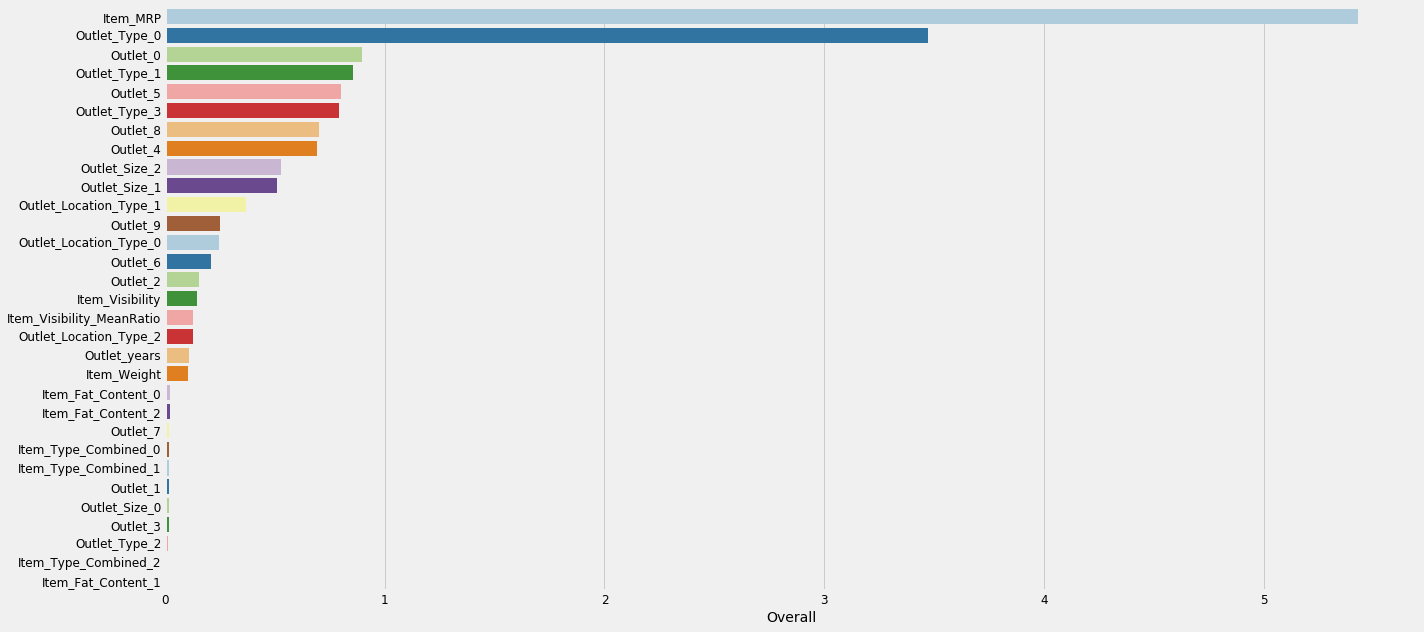

In [357]:
order_rank=feature_imp_df.sort_values('Overall',ascending=False)
fig,ax=plt.subplots(figsize=(20,10))
sns.barplot(data=order_rank,y=order_rank.index,x='Overall',palette='Paired',ax=ax)



### Model Tuning



In [362]:
# Logistic Regression Initial Parameters
log_pams = [{'n_estimators':[100,150,200,250],
             'max_depth':[5,10,15],
             'max_features':['auto','sqrt']
             }]

log_gs = GridSearchCV(rf, log_pams, scoring='neg_mean_squared_error',
                      cv=20, n_jobs=-1)

log_gs.fit(train[predictors],train[target])


GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [416]:
log_gs.best_params_,log_gs.best_score_

({'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100},
 -0.27453891220839294)

In [417]:
pred_train=(log_gs.predict(train[predictors]))

In [418]:
rmse = np.sqrt(mean_squared_error((train[target]),pred_train))
rmse

0.5142625377816192

In [419]:
test[target]=np.exp(log_gs.predict(test[predictors]))

In [420]:
 #Export submission file
IDcol.append(target)


In [421]:
modelname=pd.DataFrame({x:test[x] for x in IDcol})
modelname.to_csv('tunedrf.csv',index=False)